# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

In [2]:
#import packages 
import os 
import re
import math
import json
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
#import environment variables 
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [4]:
#log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
#import items and tester method 
from items import Item
from testing import Tester

In [ ]:
#instantiate LLMs
openai = OpenAI()
claude= Anthropic()

In [7]:
#bring in train and test pickle file 
with open('train.pkl','rb') as file:
    train= pickle.load(file)

with open('test.pkl','rb') as file:
    test = pickle.load(file)

## Human Predicted Model 

In [9]:
#write the test set to csv
import csv
with open('human_input.csv','w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(),0])

In [11]:
#read it back in 
human_predictions = []
with open('human_output.csv','r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [12]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $140.49 Error: $20.49 SLE: 0.02 Item: Sena SMH5-FM-UNIV Bluetooth Headset and ...
2: Guess: $80.00 Truth: $347.99 Error: $267.99 SLE: 2.13 Item: ONINE Thruster Drop Steps Compatible wit...
3: Guess: $35.00 Truth: $228.00 Error: $193.00 SLE: 3.42 Item: Max Factory K-ON!: Mio Akiyama PVC Figur...
4: Guess: $350.00 Truth: $43.99 Error: $306.01 SLE: 4.22 Item: Gear Head RC 1/10 Scale Six Shooter LED ...
5: Guess: $75.00 Truth: $117.25 Error: $42.25 SLE: 0.20 Item: lenovo ThinkCentre M82 SFF Business Desk...
6: Guess: $12.00 Truth: $107.99 Error: $95.99 SLE: 4.52 Item: Retractable Cargo Cover Replacement for ...
7: Guess: $115.00 Truth: $52.99 Error: $62.01 SLE: 0.58 Item: Jiayouy 51Pieces Guitar Repairing Tool K...
8: Guess: $100.00 Truth: $49.99 Error: $50.01 SLE: 0.47 Item: Spec-D Tuning LF-CV094AMOEM-RS Honda Civ...
9: Guess: $300.00 Truth: $73.00 Error: $227.00 SLE: 1.97 Item: EX120-2 4257128 Fuel Tank Float - SINOCM...
10: Guess: $80.00 Truth: $249.00 Error: $

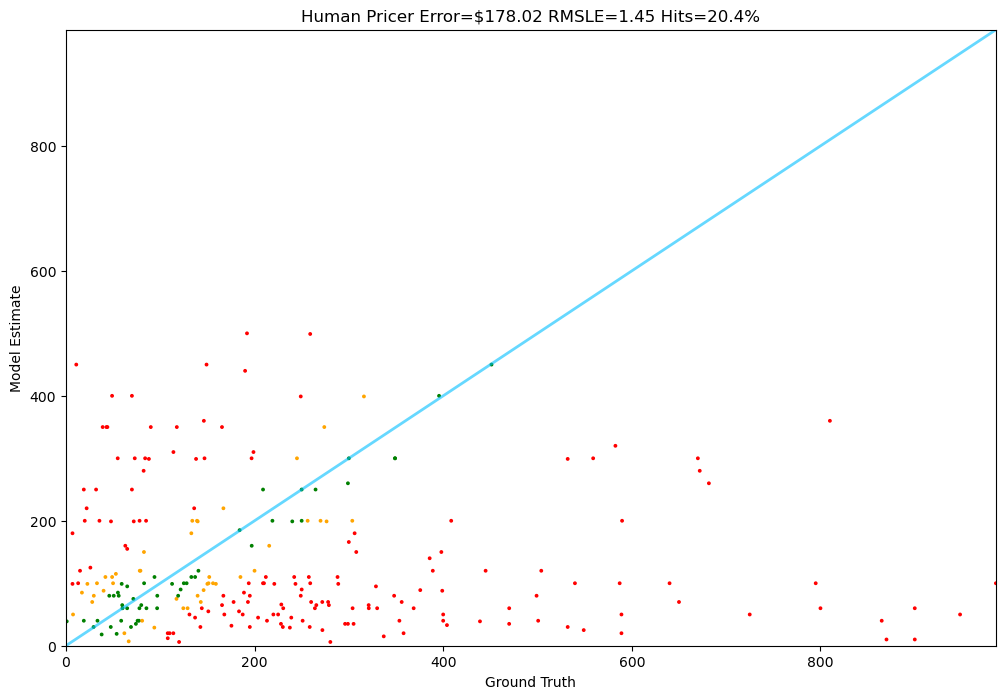

In [13]:
Tester.test(human_pricer, test)

**Human Predictions were way to off. But that was fun to predict price of chandaler!!!**

## LLM GPT-4o-mini

In [15]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification

def messages_for(item):
    system_message = "You estimate price of items.Reply only with the price, no explaination"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return[
        {"role":"system","content":system_message},
        {"role":"user", "content":user_prompt},
        {"role":"assistant","content":"Price is $"}
    ]

In [17]:
#review the prompt 
messages_for(test[1])

[{'role': 'system',
  'content': 'You estimate price of items.Reply only with the price, no explaination'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nONINE Thruster Drop Steps Compatible with Jeep Wrangler JL 4 Door Running Board Side Step Nerf Bar Rock Slider, Textured Black Heavy Duty Steel\nExpertly crafted from premium materials Made by cold rolled steel with 3 stage textured black powder coated process to resist from rust and corrosion. high strength mounting bracket, holds up to 500 Lbs on each side Designed to match rigorous quality standards：ONINE Thruster drop side steps with 5.2” width footing step area easy for you step in and out of vehicle. Wide steps and an extremely-durable construction emphasize the strong DNA of your vehicle Arm your car The drop side steps provide extra protect of your rocker panel to reduce collision impact and prevent direct door damaged Easy custom fit No-drill installation bolts right to factory mounting'},
 {'role': 'assistant',

In [18]:
#review the prompt 
messages_for(test[2])

[{'role': 'system',
  'content': 'You estimate price of items.Reply only with the price, no explaination'},
 {'role': 'user',
  'content': "How much does this cost?\n\nMax Factory K-ON! Mio Akiyama PVC Figure (1 7 Scale)\nFrom Max Factory. Following on from Ritsu's 1/7th scale figure comes another 1/7th scale PVC figure from the ever popular K-ON!, this time of Sakura High's left handed bassist, Mio Akiyama! Dressed in the Gothic Lolita dress she wore at the stage of the school festival, Mio is embracing her beloved bass guitar Elisabeth close to her heart in a pose that really shows her cute embarrassed side. Elisabeth has been faithfully recreated to look just like the real guitar, with careful details included even on the pickguard and controller. A Max Factory import From the hit anime Figure is in 1 7 scale Dimensions "},
 {'role': 'assistant', 'content': 'Price is $'}]

In [ ]:
# a utility function to extract price from a string
# this fuction will make sure even of LLM gives a bigger response in form of string
# we will take numerical value and chop of  the rest
def get_price(s): #takes astring
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [21]:
#dry run
get_price("The price is roughly 99.99 because blah blah")

99.99

In [22]:
#method of gpt-40-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model = "gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [23]:
test[0].price

140.49

1: Guess: $149.99 Truth: $140.49 Error: $9.50 SLE: 0.00 Item: Sena SMH5-FM-UNIV Bluetooth Headset and ...
2: Guess: $299.99 Truth: $347.99 Error: $48.00 SLE: 0.02 Item: ONINE Thruster Drop Steps Compatible wit...
3: Guess: $180.00 Truth: $228.00 Error: $48.00 SLE: 0.06 Item: Max Factory K-ON!: Mio Akiyama PVC Figur...
4: Guess: $30.99 Truth: $43.99 Error: $13.00 SLE: 0.12 Item: Gear Head RC 1/10 Scale Six Shooter LED ...
5: Guess: $229.99 Truth: $117.25 Error: $112.74 SLE: 0.45 Item: lenovo ThinkCentre M82 SFF Business Desk...
6: Guess: $150.00 Truth: $107.99 Error: $42.01 SLE: 0.11 Item: Retractable Cargo Cover Replacement for ...
7: Guess: $29.99 Truth: $52.99 Error: $23.00 SLE: 0.31 Item: Jiayouy 51Pieces Guitar Repairing Tool K...
8: Guess: $50.00 Truth: $49.99 Error: $0.01 SLE: 0.00 Item: Spec-D Tuning LF-CV094AMOEM-RS Honda Civ...
9: Guess: $35.99 Truth: $73.00 Error: $37.01 SLE: 0.48 Item: EX120-2 4257128 Fuel Tank Float - SINOCM...
10: Guess: $279.99 Truth: $249.00 Error: $30.9

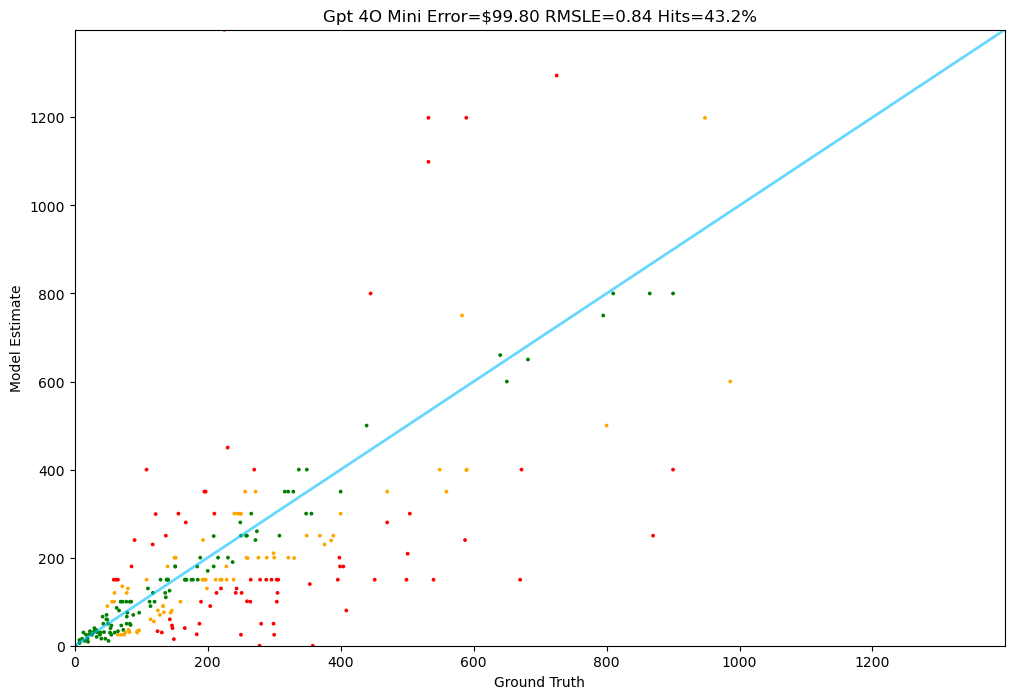

In [24]:
#call the tester method 
Tester.test(gpt_4o_mini,test)

**It would be safe to say the gpt_4o_mini LLM has crushed all of the previous models at a jarring point of error $99.80 which is best so far**

## GPT-4o-2024-08-06 Model 

In [25]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $99.00 Truth: $140.49 Error: $41.49 SLE: 0.12 Item: Sena SMH5-FM-UNIV Bluetooth Headset and ...
2: Guess: $349.99 Truth: $347.99 Error: $2.00 SLE: 0.00 Item: ONINE Thruster Drop Steps Compatible wit...
3: Guess: $150.00 Truth: $228.00 Error: $78.00 SLE: 0.17 Item: Max Factory K-ON!: Mio Akiyama PVC Figur...
4: Guess: $29.99 Truth: $43.99 Error: $14.00 SLE: 0.14 Item: Gear Head RC 1/10 Scale Six Shooter LED ...
5: Guess: $280.00 Truth: $117.25 Error: $162.75 SLE: 0.75 Item: lenovo ThinkCentre M82 SFF Business Desk...
6: Guess: $150.00 Truth: $107.99 Error: $42.01 SLE: 0.11 Item: Retractable Cargo Cover Replacement for ...
7: Guess: $24.99 Truth: $52.99 Error: $28.00 SLE: 0.53 Item: Jiayouy 51Pieces Guitar Repairing Tool K...
8: Guess: $100.00 Truth: $49.99 Error: $50.01 SLE: 0.47 Item: Spec-D Tuning LF-CV094AMOEM-RS Honda Civ...
9: Guess: $35.00 Truth: $73.00 Error: $38.00 SLE: 0.52 Item: EX120-2 4257128 Fuel Tank Float - SINOCM...
10: Guess: $0.00 Truth: $249.00 Error: $249.0

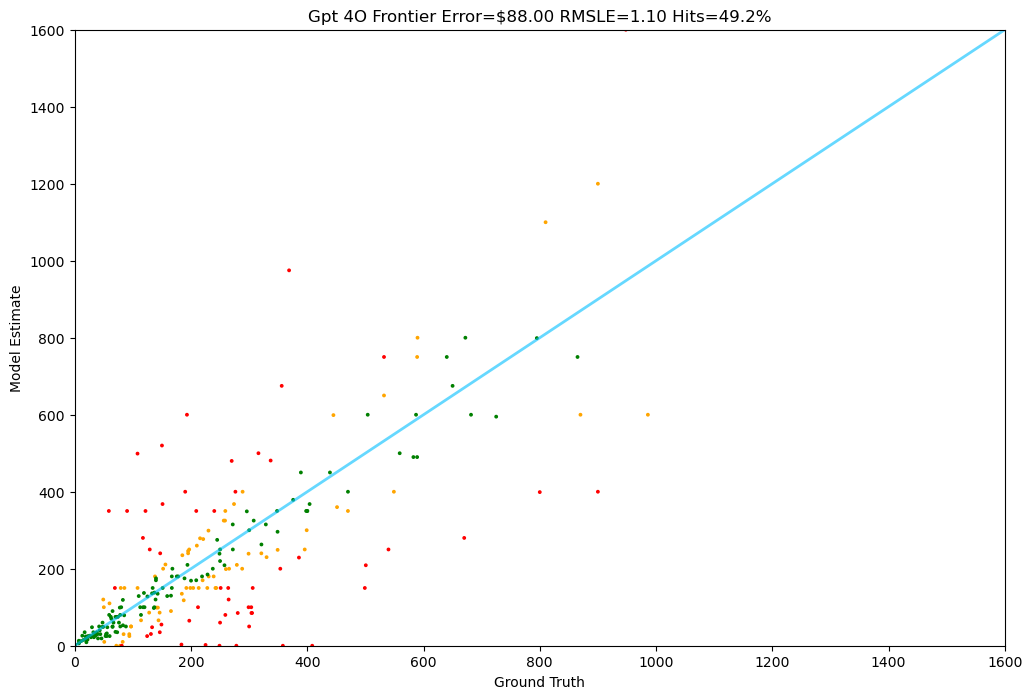

In [26]:
# The function for gpt-4o - the August model
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

**It would be safe to say the gpt_4o is smarter than gpt_4o_mini LLM in this use case has crushed all of the previous models at a jarring point of error $88 which is best so far**

## Claude Sonnet 

In [27]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $129.99 Truth: $140.49 Error: $10.50 SLE: 0.01 Item: Sena SMH5-FM-UNIV Bluetooth Headset and ...
2: Guess: $429.99 Truth: $347.99 Error: $82.00 SLE: 0.04 Item: ONINE Thruster Drop Steps Compatible wit...
3: Guess: $34.99 Truth: $228.00 Error: $193.01 SLE: 3.42 Item: Max Factory K-ON!: Mio Akiyama PVC Figur...
4: Guess: $29.99 Truth: $43.99 Error: $14.00 SLE: 0.14 Item: Gear Head RC 1/10 Scale Six Shooter LED ...
5: Guess: $289.99 Truth: $117.25 Error: $172.74 SLE: 0.81 Item: lenovo ThinkCentre M82 SFF Business Desk...
6: Guess: $89.99 Truth: $107.99 Error: $18.00 SLE: 0.03 Item: Retractable Cargo Cover Replacement for ...
7: Guess: $29.99 Truth: $52.99 Error: $23.00 SLE: 0.31 Item: Jiayouy 51Pieces Guitar Repairing Tool K...
8: Guess: $59.99 Truth: $49.99 Error: $10.00 SLE: 0.03 Item: Spec-D Tuning LF-CV094AMOEM-RS Honda Civ...
9: Guess: $49.99 Truth: $73.00 Error: $23.01 SLE: 0.14 Item: EX120-2 4257128 Fuel Tank Float - SINOCM...
10: Guess: $239.99 Truth: $249.00 Error: $9.0

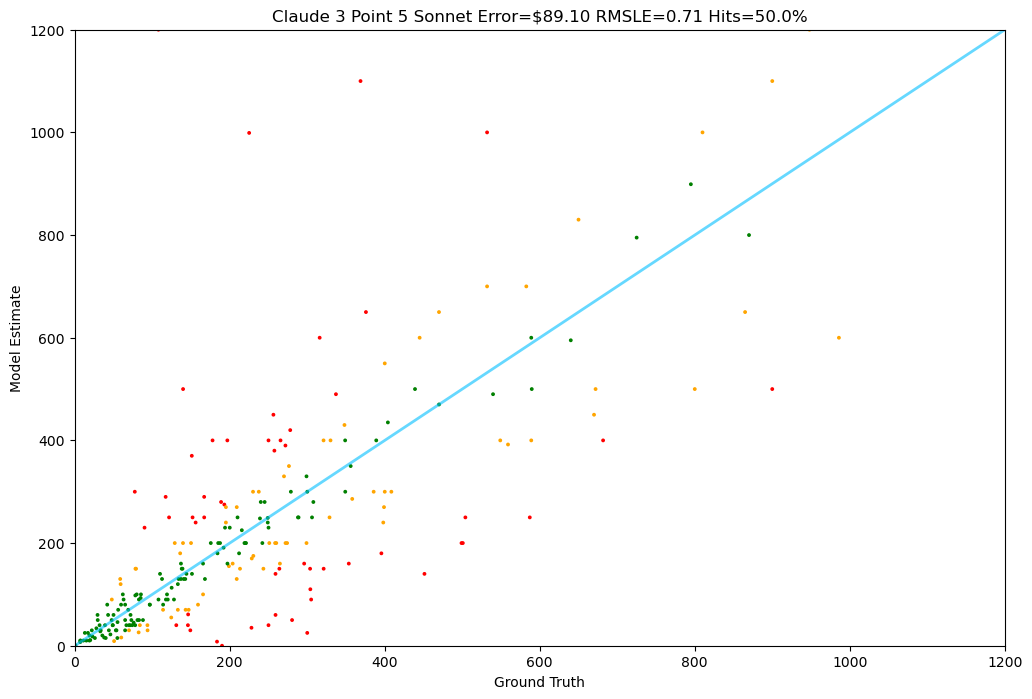

In [28]:
Tester.test(claude_3_point_5_sonnet, test)

**It would be safe to say the gpt_4o and Claude Sonnet LLM are similar in there guesses in this use case has crushed all of the previous models at a jarring point of error $88-89 which is best so far**